## Title
What do I do in this notebook

In [308]:
import pandas as pd
import numpy as np

In [309]:
df = pd.read_csv('data/nyc_bike_accidents.csv')
pd.options.display.max_columns = 50
df

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,27,2021-12-14,12:54,BROOKLYN,11217.0,40.687534,-73.977500,"(40.687534, -73.9775)",FULTON STREET,SAINT FELIX STREET,NaN,1.0,0.0,1,0,Unspecified,Unspecified,NaN,NaN,NaN,4487052,Sedan,Bike,NaN,NaN,NaN
1,31,2021-12-14,16:25,NaN,NaN,40.784615,-73.953964,"(40.784615, -73.953964)",EAST 93 STREET,NaN,NaN,1.0,0.0,1,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4486581,Van,Bike,NaN,NaN,NaN
2,51,2022-04-24,15:35,MANHATTAN,10019.0,40.767242,-73.986206,"(40.767242, -73.986206)",WEST 56 STREET,9 AVENUE,NaN,1.0,0.0,1,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4521853,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
3,66,2021-12-09,20:20,BROOKLYN,11223.0,40.592070,-73.962990,"(40.59207, -73.96299)",EAST 7 STREET,CRAWFORD AVENUE,NaN,1.0,0.0,1,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4485150,Bike,NaN,NaN,NaN,NaN
4,72,2021-12-09,23:15,BROOKLYN,11218.0,40.640835,-73.989670,"(40.640835, -73.98967)",12 AVENUE,41 STREET,NaN,1.0,0.0,1,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4485355,Sedan,Bike,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49505,1964049,2023-01-24,17:35,BROOKLYN,11219.0,40.636566,-73.997696,"(40.636566, -73.997696)",51 STREET,11 AVENUE,NaN,1.0,0.0,1,0,Unspecified,NaN,NaN,NaN,NaN,4600342,Bike,NaN,NaN,NaN,NaN
49506,1964058,2023-01-24,15:57,BROOKLYN,11215.0,40.667250,-73.994550,"(40.66725, -73.99455)",3 AVENUE,16 STREET,NaN,1.0,0.0,1,0,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,4600353,Sedan,Bike,NaN,NaN,NaN
49507,1964064,2023-01-24,14:10,BRONX,10454.0,40.810726,-73.924650,"(40.810726, -73.92465)",EAST 139 STREET,ALEXANDER AVENUE,NaN,1.0,0.0,1,0,Unsafe Speed,Traffic Control Disregarded,NaN,NaN,NaN,4600464,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
49508,1964105,2023-01-24,15:00,BROOKLYN,11220.0,40.640263,-74.019035,"(40.640263, -74.019035)",4 AVENUE,61 STREET,NaN,1.0,0.0,1,0,Unspecified,Unspecified,NaN,NaN,NaN,4600585,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN


In [310]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

df['YEAR'] = df['CRASH DATE'].dt.strftime('%Y')

In [311]:
df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)
df

nyc_bike_accidents_2018_2022 = df[df['YEAR'].str.contains('2018|2019|2020|2021|2022')]
nyc_bike_accidents_2018_2022 = nyc_bike_accidents_2018_2022[['YEAR','LATITUDE', 'LONGITUDE','NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]

# And create new columns that will be used for visualization
nyc_bike_accidents_2018_2022['ACCIDENT TYPE'] = 0

nyc_bike_accidents_2018_2022.loc[nyc_bike_accidents_2018_2022['NUMBER OF CYCLIST INJURED'] > 0, 'ACCIDENT TYPE'] = 'Injured'
nyc_bike_accidents_2018_2022.loc[nyc_bike_accidents_2018_2022['NUMBER OF CYCLIST KILLED'] > 0, 'ACCIDENT TYPE'] = 'Fatal'

nyc_bike_accidents_2018_2022

,YEAR,LATITUDE,LONGITUDE,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,ACCIDENT TYPE
0,2021,40.687534,-73.977500,1,0,Injured
1,2021,40.784615,-73.953964,1,0,Injured
2,2022,40.767242,-73.986206,1,0,Injured
3,2021,40.592070,-73.962990,1,0,Injured
4,2021,40.640835,-73.989670,1,0,Injured
...,...,...,...,...,...,...
49439,2022,40.697758,-73.793330,1,0,Injured
49441,2022,40.629870,-73.977005,1,0,Injured
49494,2022,40.748245,-73.976295,1,0,Injured
49499,2022,40.812430,-73.903130,1,0,Injured


In [312]:
nyc_bike_accidents_2018_2022.to_csv('data/nyc_bike_accidents_2018_2022.csv', index=False)

### Reasons for accidents

In [313]:
bike_df = df.groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().sort_values('NUMBER OF PERSONS INJURED', ascending=False).reset_index()
bike_df = bike_df[['CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]

# Drop the first row, because that is the cases where the reason was unspecified.
bike_df.drop(index=0, inplace=True)

# Get top 10 reasons
bike_df = bike_df.head(10)

In [314]:
bike_df.to_csv('data/nyc_accidents_reason.csv')

In [315]:
#bike_df_2022 = df[df['YEAR'] == '2022']
bike_df = df

#Standardize the vehicle types
bike_df.replace(['E-Bike', 'BICYCLE', 'E-Bik'], 'Bike')

# Create a column that specifies if the vehicle type was a bike or not.
bike_df['vehicle_1_bike'] = np.where(bike_df['VEHICLE TYPE CODE 1'] == 'Bike', 0, 1)

# Group by the vehicle type and the reason for the accident.
bike_df = bike_df.groupby(['vehicle_1_bike','CONTRIBUTING FACTOR VEHICLE 1']).sum().sort_values('NUMBER OF PERSONS INJURED', ascending=False).reset_index()
bike_df = bike_df[['CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'vehicle_1_bike']]

# Drop the rows where the reason was unspecified.
bike_df = bike_df[bike_df["CONTRIBUTING FACTOR VEHICLE 1"].str.contains("Unspecified") == False]

bike_df.head(50)

,CONTRIBUTING FACTOR VEHICLE 1,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,vehicle_1_bike
1,Driver Inattention/Distraction,9401,25,1
2,Failure to Yield Right-of-Way,4448,7,1
3,Driver Inattention/Distraction,2352,2,0
4,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,2356,20,1
6,Traffic Control Disregarded,1600,13,1
7,Passenger Distraction,1464,7,1
8,Passing or Lane Usage Improper,1052,4,1
9,Failure to Yield Right-of-Way,908,5,0
10,Other Vehicular,801,4,1
11,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,717,4,0


In [316]:
bike_df_10 = bike_df.head(10)
bike_df_10

,CONTRIBUTING FACTOR VEHICLE 1,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,vehicle_1_bike
1,Driver Inattention/Distraction,9401,25,1
2,Failure to Yield Right-of-Way,4448,7,1
3,Driver Inattention/Distraction,2352,2,0
4,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,2356,20,1
6,Traffic Control Disregarded,1600,13,1
7,Passenger Distraction,1464,7,1
8,Passing or Lane Usage Improper,1052,4,1
9,Failure to Yield Right-of-Way,908,5,0
10,Other Vehicular,801,4,1
11,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,717,4,0


In [317]:
bike_df_10.to_csv('data/nyc_accidents_reason_10.csv')

### Prepare accident data for mapping

In this section of the notebook I prepare the accident data to be mapped as dots on a datawrapper map. For the mapping I need information about the location of the accident, whether the cyclist was injured or killed (to color the dots depending on it).

In [318]:
df.groupby('YEAR').sum('NUMBER OF PERSONS KILLED')

,Unnamed: 0,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,COLLISION_ID,vehicle_1_bike
YEAR,,,,,,,,,,
2012,3789847104,21810871.0,82042.521399,-148985.590667,2058.0,6.0,2021,6,302982984,2015
2013,6374228922,40091890.0,151193.640470,-274536.520564,3768.0,8.0,3725,8,525814550,3713
2014,5550244111,39608844.0,149907.740100,-272167.003660,3729.0,16.0,3681,16,3865115452,3680
2015,5006430481,41577236.0,157682.844458,-286286.717771,3935.0,15.0,3884,15,12653422642,3871
2016,4571252281,35119336.0,173723.351518,-315427.251408,4401.0,13.0,4308,13,15020782782,3306
2017,3860317004,35140875.0,185856.188187,-337464.337220,4660.0,31.0,4580,24,16968539230,3050
2018,2716060279,35684611.0,180279.764749,-327330.195093,4575.0,9.0,4460,9,17484041614,2742
2019,1835687992,37791538.0,191075.813372,-346917.387261,4789.0,29.0,4714,29,19584532445,3686
2020,1170515404,42011082.0,210935.405135,-382899.818754,5374.0,25.0,5276,24,22498290869,4195


In [319]:
# Get only the data from 2022
df_2022 = df[df['YEAR'] == '2022']

# Get only the columns we need
df_2022 = df_2022[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF CYCLIST INJURED', 'ON STREET NAME', 'CROSS STREET NAME']]

# And create new columns that will be used for visualization
df_2022['ACCIDENT TYPE'] = 0

df_2022.loc[df_2022['NUMBER OF CYCLIST INJURED'] > 0, 'ACCIDENT TYPE'] = 'Injured'
df_2022.loc[df_2022['NUMBER OF CYCLIST KILLED'] > 0, 'ACCIDENT TYPE'] = 'Fatal'

df_2022['INJURED OR DEATH'] = df_2022['NUMBER OF CYCLIST KILLED'] + df_2022['NUMBER OF CYCLIST INJURED']

df_2022.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

In [320]:
df_2022.to_csv('data/nyc_bike_crashes_2022.csv')

And to check if any streets are particularly dangerous for cyclists.

In [321]:
df_2022.groupby('ON STREET NAME').sum().sort_values('INJURED OR DEATH', ascending=False).head(50)

,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF CYCLIST KILLED,NUMBER OF CYCLIST INJURED,INJURED OR DEATH
ON STREET NAME,,,,,,
BROADWAY,574128.0,3546.749792,-6432.960127,0,90,90
4 AVENUE,659666.0,2846.366428,-5179.957104,0,71,71
3 AVENUE,375181.0,2119.210039,-3845.993052,0,54,54
BEDFORD AVENUE,246820.0,1911.458332,-3475.896218,0,48,48
2 AVENUE,363463.0,1711.774058,-3106.570754,1,43,44
5 AVENUE,282135.0,1750.510665,-3181.335502,0,43,43
1 AVENUE,200441.0,1385.812630,-2514.717171,0,37,37
8 AVENUE,260243.0,1385.647392,-2515.101474,0,34,34
7 AVENUE,187526.0,1222.081275,-2219.443542,0,30,30


### Development of accidents over time

In [322]:
accidents = pd.read_csv('data/nyc_bike_accidents.csv')

bikers = pd.read_csv('data/nyc_bikerides_numbers.csv')

In [323]:
accidents['CRASH DATE'] = pd.to_datetime(accidents['CRASH DATE'])

accidents['YEAR'] = accidents['CRASH DATE'].dt.strftime('%Y')

accidents_year = accidents.groupby('YEAR').sum('NUMBER OF PERSONS KILLED')
accidents_year = accidents_year[['NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']]
accidents_year

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
YEAR,,
2012,2210,6
2013,4075,11
2014,4000,20
2015,4281,15
2016,4975,18
2017,4889,27
2018,4725,10
2019,4986,31
2020,5576,29


In [324]:
accidents_year = accidents_year.reset_index()

accidents_year.rename(columns={"YEAR": "year", "NUMBER OF CYCLIST INJURED": "injured", "NUMBER OF CYCLIST KILLED": "killed"}, inplace=True)

accidents_year

,year,injured,killed
0,2012,2210,6
1,2013,4075,11
2,2014,4000,20
3,2015,4281,15
4,2016,4975,18
5,2017,4889,27
6,2018,4725,10
7,2019,4986,31
8,2020,5576,29
9,2021,4961,19


In [325]:
bikers['year'] = bikers['Unnamed: 0']
bikers = bikers[['year', 'Total Daily Cycling Trips']]
bikers

,year,Total Daily Cycling Trips
0,2008,240000.0
1,2009,240000.0
2,2010,250000.0
3,2011,270000.0
4,2012,320000.0
5,2013,380000.0
6,2014,420000.0
7,2015,450000.0
8,2016,460000.0
9,2017,490000.0


In [326]:
bikers.drop([13], inplace=True)
bikers

,year,Total Daily Cycling Trips
0,2008,240000.0
1,2009,240000.0
2,2010,250000.0
3,2011,270000.0
4,2012,320000.0
5,2013,380000.0
6,2014,420000.0
7,2015,450000.0
8,2016,460000.0
9,2017,490000.0


In [327]:
bikers_accidents = pd.merge(accidents_year, bikers, on=['year'], how='left')


# Standardize the injuries and deaths per 1 million rides
bikers_accidents['injury_rate'] = bikers_accidents['injured'] / (bikers_accidents['Total Daily Cycling Trips'] * 365) * 1000000
bikers_accidents['fatality_rate'] = bikers_accidents['killed'] / (bikers_accidents['Total Daily Cycling Trips'] * 365) * 1000000

bikers_accidents.rename({'Total Daily Cycling Trips': 'total_daily_bikerides'}, axis=1, inplace=True)

In [328]:
bikers_accidents = bikers_accidents[['year', 'injury_rate', 'fatality_rate']]
bikers_accidents

,year,injury_rate,fatality_rate
0,2012,18.921233,0.051370
1,2013,29.379957,0.079308
2,2014,26.092629,0.130463
3,2015,26.063927,0.091324
4,2016,29.630733,0.107207
5,2017,27.335756,0.150964
6,2018,25.382756,0.053720
7,2019,25.774102,0.160248
8,2020,NaN,NaN
9,2021,24.712329,0.094645


In [329]:
bikers_accidents.to_csv('data/accidents_development.csv', index=False)

In [336]:
bikers_injuries = bikers_accidents[['year', 'cyclists injured']]
bikers_injuries.to_csv('data/injuries_development.csv', index=False)

,year,cyclists injured
0,2012,18.921233
1,2013,29.379957
2,2014,26.092629
3,2015,26.063927
4,2016,29.630733
5,2017,27.335756
6,2018,25.382756
7,2019,25.774102
8,2020,NaN
9,2021,24.712329


In [330]:
bikers_accidents.columns = ['year', 'cyclists injured', 'cyclists deaths']

melt = pd.melt(bikers_accidents, id_vars=['year'], value_vars=['cyclists injured', 'cyclists deaths'], var_name='accident_type', value_name='rate')
melt = melt[melt['rate'].notna()]
melt['year'] = melt['year'].astype(int)

melt.to_csv('data/accidents_development_cleaned.csv', index=False)

In [331]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [332]:
%%R

require('ggplot2')
require('readr')
require('extrafont')
require('dplyr')
require('reshape2')
require('tidyverse')

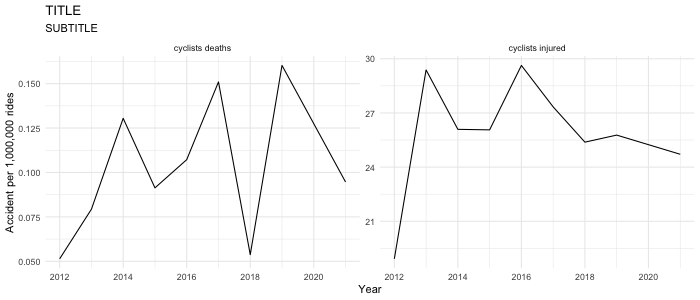

In [333]:
%%R -i melt -w 700 -h 300

ggplot(melt, aes(x=year, y=rate)) +
  geom_line() +
  facet_wrap(~accident_type, scales='free_y', ncol=2) +
  theme_minimal()+
    labs(
    x = 'Year',
    y = 'Accident per 1,000,000 rides',
    title = 'TITLE',
    subtitle = 'SUBTITLE',
    )